# RQ 4 (Encapsulation)

>  Is unsafe code typically shielded from clients through safe abstractions?


## Setup

In [1]:
# import libraries
import itertools
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree

import utils
import top_crates
from whitelists import *
from drawing import *

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [2]:
# Load tables
function_definitions = utils.load_selected_function_definitions()
const_calls = utils.load_const_calls()
selected_builds = utils.load_selected_builds()

# Rename confusing columns
const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)

# Preprocessing
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"].copy()
cross_crate_const_calls = const_calls[const_calls.crate_callsite != const_calls.crate_defsite]
same_crate_const_calls = const_calls[const_calls.crate_callsite == const_calls.crate_defsite]

In [3]:
# Validation
assert function_definitions[function_definitions.unsafety == "Unknown"].abi.unique() == ["Closure"]

In [4]:
# Whitelists
all_crate_names = (
    set(const_calls.crate_defsite.unique())
    | set(const_calls.crate_callsite.unique())
    | set(function_definitions[
        function_definitions.crate.notnull()
    ].crate.unique())
)
all_function_names = function_definitions.def_path.unique()

# sys_crate_names = get_sys_crate_names(all_crate_names)
# unchecked_function_names = get_unchecked_function_names(all_function_names)

# Validation
assert "std" in all_crate_names

## Query 6

> We then count *how many unsafe functions are (1) declared private, (2) visible within their crate,
and (3) visible to other crates.*

#### Results from the paper for comparison (Table 2)

|Visibility| #functions      |    %  |
| ------------- |--------------|-------|
| Private       | 65,230       |  11.7 |
| Restricted    | 1,535        |   0.3 |
| Public        | 489,928      |  87.9 |

In [5]:
print("unsafe_function_definitions:", len(unsafe_function_definitions))

# In our dataset the 'Unknown' rows coincide with the trait items
assert (unsafe_function_definitions.visibility == "Unknown").equals(unsafe_function_definitions.is_trait_item)

print("The 'Unknown' are trait methods")
unsafe_function_definitions.visibility.value_counts()

unsafe_function_definitions: 557380
The 'Unknown' are trait methods


Public        489928
Private        65230
Crate           1378
Unknown          687
Restricted       157
Name: visibility, dtype: int64

Total number of unsafe functions: 557380
Total number of trait-method unsafe functions: 687 (0.123255%)
Total number of non-trait-method unsafe functions:556693 (99.876745%)
is_public        489928
is_private        65230
is_restricted      1535
dtype: int64
is_public        88.006855
is_private       11.717410
is_restricted     0.275735
dtype: float64


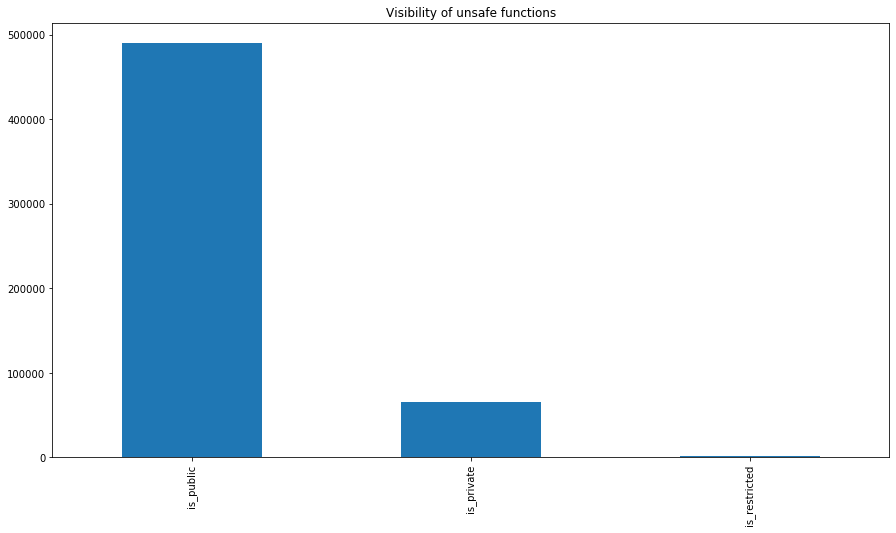

In [6]:
# Visibility of functions
unsafe_function_definitions["is_private"] = unsafe_function_definitions.visibility == "Private"
unsafe_function_definitions["is_restricted"] = unsafe_function_definitions.visibility.isin(set(["Crate", "Restricted"]))
unsafe_function_definitions["is_public"] = unsafe_function_definitions.visibility == "Public"

unsafe_function_definitions["is_private_or_restricted"] = unsafe_function_definitions.is_private | unsafe_function_definitions.is_restricted

unsafe_function_definitions["is_public_and_used_from_another_crate"] = (
    unsafe_function_definitions["is_public"]
    & unsafe_function_definitions.def_path.isin(set(cross_crate_const_calls.def_path.unique()))
)
unsafe_function_definitions["is_public_and_used_only_from_the_same_crate"] = (
    unsafe_function_definitions["is_public"]
    & ~unsafe_function_definitions["is_public_and_used_from_another_crate"]
    & unsafe_function_definitions.def_path.isin(set(same_crate_const_calls.def_path.unique()))
)
unsafe_function_definitions["is_public_and_unused"] = (
    unsafe_function_definitions["is_public"]
    & ~unsafe_function_definitions["is_public_and_used_from_another_crate"]
    & ~unsafe_function_definitions["is_public_and_used_only_from_the_same_crate"]
)

feature_names = [
    "is_private",
    "is_restricted",
    "is_public",
]

num_trait_methods = sum(unsafe_function_definitions.is_trait_item)
num_non_trait_methods = sum(~unsafe_function_definitions.is_trait_item)

# Validation: there are no trait methods left
assert sum([sum(unsafe_function_definitions[f]) for f in feature_names]) == num_non_trait_methods
assert len(unsafe_function_definitions) == num_trait_methods + num_non_trait_methods

print("Total number of unsafe functions:", len(unsafe_function_definitions))
print("Total number of trait-method unsafe functions: {} ({:%})".format(
    num_trait_methods, num_trait_methods/len(unsafe_function_definitions))
)
print("Total number of non-trait-method unsafe functions:{} ({:%})".format(
    num_non_trait_methods, num_non_trait_methods/len(unsafe_function_definitions))
)

features_frequency = unsafe_function_definitions[feature_names].apply(sum).sort_values(ascending=False)
features_frequency.plot.bar(title="Visibility of unsafe functions")
print(features_frequency)
print(features_frequency/num_non_trait_methods * 100)

## Follow-up 1

> The results are depicted in Fig. 9. Based on this updated metric, we get a clearer picture: most crates (78.5%) have either all or none of their unsafe functions declared public. In particular, 34.7% of all crates seem to be well encapsulated: they declare unsafe functions but none of them are visible from the outside.

Fig.9:

![Fig.9](pics/rq4-distribution.png)

In [7]:
public_unsafe_function_counts = dict(
    unsafe_function_definitions.query('is_public').build.value_counts().iteritems())
non_public_unsafe_function_counts = dict(unsafe_function_definitions.query('is_private_or_restricted').build.value_counts().iteritems())
unsafe_function_proportions = []
for (_, row) in selected_builds.iterrows():
    build = row['build']
    public_count = public_unsafe_function_counts.get(build) or 0
    non_public_count = non_public_unsafe_function_counts.get(build) or 0
    count = (non_public_count+public_count)
    if count > 0:
        row["public_count"] = public_count
        row["non_public_count"] = non_public_count
        row["total"] = count
        row["public_proportion"] = public_count/count
        unsafe_function_proportions.append(row)
unsafe_function_proportions = pd.DataFrame(data=unsafe_function_proportions)

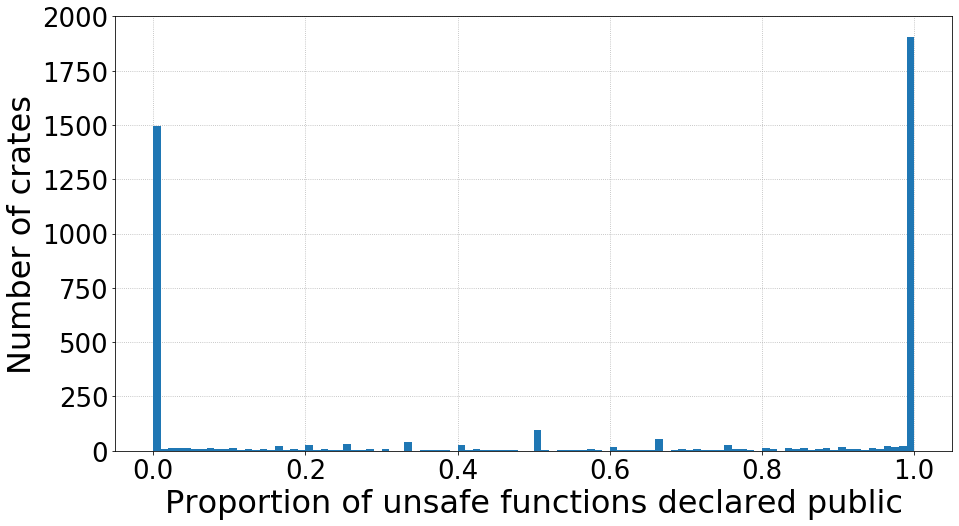

In [8]:
ax = unsafe_function_proportions.public_proportion.plot.hist(
 bins=100,
 linewidth=4,
 fontsize=26,
)
ax.title.set_size(20)
ax.set_xlabel("Proportion of unsafe functions declared public", fontsize=32)
ax.set_ylabel("Number of crates", fontsize=32)
ax.set_axisbelow(True)
ax.grid(True, linestyle='dotted')
plt.show()

> Moreover, 43.8% of crates declare all of their unsafe functions public;

In [9]:
# Proportions:
non_public_dominated_builds = set(
    unsafe_function_proportions.query("public_count == 0").build)
non_public_dominated_builds_count = len(non_public_dominated_builds)
print("{} ({}%) builds (of {}) with unsafe functions have no public unsafe functions".format(
    non_public_dominated_builds_count,
    100*non_public_dominated_builds_count/len(unsafe_function_proportions),
    len(unsafe_function_proportions)
))
public_dominated_builds = set(
    unsafe_function_proportions.query("non_public_count == 0").build)
public_dominated_builds_count = len(public_dominated_builds)
print("{} ({}%) builds (of {}) with unsafe functions have only public unsafe function".format(
    public_dominated_builds_count,
    100*public_dominated_builds_count/len(unsafe_function_proportions),
    len(unsafe_function_proportions)
))
assert len(unsafe_function_proportions.query("non_public_count == 0 and public_count == 0")) == 0
dominated_builds_count = non_public_dominated_builds_count + public_dominated_builds_count
print("{} ({}%) builds (of {}) with unsafe functions have either all unsafe function private or public".format(
    dominated_builds_count,
    100*dominated_builds_count/len(unsafe_function_proportions),
    len(unsafe_function_proportions)
))

1486 (34.7196261682243%) builds (of 4280) with unsafe functions have no public unsafe functions
1873 (43.76168224299065%) builds (of 4280) with unsafe functions have only public unsafe function
3359 (78.48130841121495%) builds (of 4280) with unsafe functions have either all unsafe function private or public


## Follow-up 2

> more precisely, these crates contain 274434 (49.2%) unsafe functions.

In [10]:
# Unsafe functions from the public dominated tower.
public_unsafe_functions = unsafe_function_definitions[
    unsafe_function_definitions["build"].isin(public_dominated_builds)
].query("not is_trait_item")
assert len(public_unsafe_functions) > 0, len(public_unsafe_functions)
assert len(public_unsafe_functions.query("not is_public")) == 0, len(public_unsafe_functions.query("not is_public"))
public_unsafe_functions_count = len(public_unsafe_functions)
print("The public dominated tower contains {} ({}%) from {} unsafe functions".format(
      public_unsafe_functions_count,
      100*public_unsafe_functions_count/len(unsafe_function_definitions),
      len(unsafe_function_definitions),
))

The public dominated tower contains 274434 (49.23642757185403%) from 557380 unsafe functions


> We found that 163,650 (59.6%) have foreign item ABI, which means that they are bindings of foreign items (most likely C functions). We also found that 571 (0.2%) functions have C ABI, which means that they can be called from C code and, therefore, it makes sense to have them public. The vast majority of the remaining functions (110,212 or 40.2%) have Rust ABI and, therefore, it is hard to automatically tell whether they are bindings or not.

In [11]:
def show_abi_counts(functions, total_count):
    abi_counts = functions.abi.value_counts()
    print("Counts:")
    print(abi_counts)
    print()
    print("Proportions:")
    print(abi_counts/len(functions) * 100)
    print()
    print("Of all:")
    print(abi_counts/total_count * 100)

In [12]:
# Show ABIs of the public dominated tower
show_abi_counts(public_unsafe_functions, public_unsafe_functions_count)
# Keep only Rust ABI
public_rust_unsafe_functions = public_unsafe_functions.query("abi == 'Rust'")

Counts:
ForeignItem    163650
Rust           110212
C                 571
system              1
Name: abi, dtype: int64

Proportions:
ForeignItem    59.631824
Rust           40.159747
C               0.208065
system          0.000364
Name: abi, dtype: float64

Of all:
ForeignItem    59.631824
Rust           40.159747
C               0.208065
system          0.000364
Name: abi, dtype: float64


## Follow-up 3

> Therefore, we checked the meta information of the crates that contain these functions and found that 9,642 (3.5%) are assigned to categories that indicate them as crates that wrap system libraries and 49,363 (18.0%) are assigned to categories related to embedded programming.

In [13]:
unsafe_function_spans = utils.load_unsafe_function_spans()
categories = utils.load_categories()

In [14]:
# We collected this list by manually checking all categories.
ffi = [
    "external-ffi-bindings",
    "ffi",
    "libffi",
    "ffi-bindings",
    "cffi",
    "ffistrings",
    "api bindings",
    "api-bindings",
    "bindings",
    "ffi-bindings",
    "api-bindings",
]
ffi_builds = set(categories[categories['category'].isin(ffi)].build)

embedded = [
    "arm",
    "cortex-m",
    "embedded",
    "ESP32",
    "Embedded development",
]
embedded_builds = set(categories[categories['category'].isin(embedded)].build)
def check(name, suffix):
    return name.lower().replace('-', '_').endswith(suffix)
sys_package_names = set([
    x for x in unsafe_function_spans.package_name.unique()
    if check(x, "_sys") or
       check(x, "_bindgen") or
       check(x, "_ffi") or
       check(x, "_bindings")
])

def report_counts(fns, total_count):
    ffi_build_count = len(fns[
        fns['build'].isin(ffi_builds)
        | fns['package_name'].isin(sys_package_names)
    ])
    print('FFI:', ffi_build_count, ' or ', ffi_build_count/total_count*100, '%')

    embedded_build_count = len(fns[fns['build'].isin(embedded_builds)])
    print('embedded:', embedded_build_count,
          ' or ', embedded_build_count/total_count*100, '%')

    ffi_and_embedded_build_count = len(fns[
        fns['build'].isin(embedded_builds) &
        (fns['build'].isin(ffi_builds) |
        fns['package_name'].isin(sys_package_names))
    ])
    print('embedded and FFI:', ffi_and_embedded_build_count,
          ' or ', ffi_and_embedded_build_count/total_count*100, '%')

    ffi_or_embedded_build_count = len(fns[
        fns['build'].isin(embedded_builds) |
        fns['build'].isin(ffi_builds) |
        fns['package_name'].isin(sys_package_names)
    ])
    print('embedded or FFI:', ffi_or_embedded_build_count,
          ' or ', ffi_or_embedded_build_count/total_count*100, '%')

    fns = fns[
        (~fns['build'].isin(ffi_builds)) &
        (~fns['package_name'].isin(sys_package_names)) &
        (~fns['build'].isin(embedded_builds))
    ]
    print("remaining:", len(fns))
    
    return fns

In [15]:
public_rust_unsafe_function_spans = unsafe_function_spans[
    unsafe_function_spans["build"].isin(public_dominated_builds)
].query("abi=='Rust' and visibility=='Public'")

assert len(public_rust_unsafe_functions) == len(public_rust_unsafe_function_spans)

remaining_public_unsafe_functions = report_counts(
    public_rust_unsafe_function_spans, public_unsafe_functions_count)

FFI: 9642  or  3.5134130610638623 %
embedded: 49363  or  17.987202751845615 %
embedded and FFI: 4  or  0.0014575453478796359 %
embedded or FFI: 59001  or  21.4991582675616 %
remaining: 51211


## Follow-up 4

> Finally, we manually reviewed 30 crates from the remaining
list that have most unsafe functions (in total 41,063 functions
or 15.0%) and found that they either provide APIs to microcontrollers or OpenGL bindings. After our analysis we are left with
only 10,148 functions (or 3.7%) that are public and which may not be from the crates that provide bindings.

Review comments:

* `gdnative-*` – Rust bindings for GDNative.
* Packages with unpronouncable names typically provide APIs for some microcontrolers: `cc13x2-cc26x2-pac`, `cc13x2-cc26x2-hal`, `oxcc-stm32f767`, `stm32f469xx`, `stm32wb-pac`, `cc2538`, `xmc4800`, `xmc4700`, `efr32xg1`, `xmc4500`, `alt-sam3x8e`, `nrf52840-pac`, `stm32l432-pac`, `stm32l4x2-pac`, `xmc4400`, `lpc177x_8x`, `xmc4300`, `stm32f103xx`, `xmc4100`, `xmc4200`, `nrf52832-pac`, `nrf52`, `stm32f072x-memory-map`, `atsame54p20a`.
  * All `xmc*` packages are generated by the same author.
* `gleam`, `sparkle`, `epoxy`, `grr`, `glow`, `gfx_gl`, `ogl33`, `gles30` – OpenGL bindings
* `core`, `core_arch` – part of the standard library
* `mallumo-gls` – mostly safe OpenGl bindings, but also exposes raw bindings in the `raw` module
* `rg3d`, `surfman` – OpenGL bindings. Note: public unsafe functions are inside a private module.
* `ioctls` – IO control bindings.
* `ico_math` – exposes raw SSE extensions.

In [16]:
s = 0
array = []
for n, v in remaining_public_unsafe_functions.package_name.value_counts().iteritems():
    s += v
    print(len(array), v, 'https://crates.io/crates/' + n)
    array.append(n)
    if len(array) == 30:
        print(s)
        break

print("The number of functions:", s)
print("Percentage (of all non-trait-method functions):", s/public_unsafe_functions_count*100, "%")
print("Remaining:", len(remaining_public_unsafe_functions)-s)
print("Percentage (of all non-trait-method functions):",
      (len(remaining_public_unsafe_functions)-s)/public_unsafe_functions_count*100, "%")

0 4267 https://crates.io/crates/cc13x2-cc26x2-pac
1 4267 https://crates.io/crates/cc13x2-cc26x2-hal
2 3149 https://crates.io/crates/oxcc-stm32f767
3 2644 https://crates.io/crates/stm32f469xx
4 1771 https://crates.io/crates/sparkle
5 1737 https://crates.io/crates/stm32wb-pac
6 1625 https://crates.io/crates/epoxy
7 1325 https://crates.io/crates/cc2538
8 1296 https://crates.io/crates/xmc4800
9 1295 https://crates.io/crates/xmc4700
10 1228 https://crates.io/crates/efr32xg1
11 1168 https://crates.io/crates/xmc4500
12 1146 https://crates.io/crates/alt-sam3x8e
13 1072 https://crates.io/crates/nrf52840-pac
14 1068 https://crates.io/crates/stm32l432-pac
15 1068 https://crates.io/crates/stm32l4x2-pac
16 1060 https://crates.io/crates/xmc4400
17 1017 https://crates.io/crates/lpc177x_8x
18 984 https://crates.io/crates/xmc4300
19 881 https://crates.io/crates/stm32f103xx
20 873 https://crates.io/crates/xmc4200
21 873 https://crates.io/crates/xmc4100
22 867 https://crates.io/crates/nrf52832-pac
23 866